In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

In [73]:
predictors = [LogisticRegression(), RandomForestClassifier()]

In [74]:
kfold = KFold(n_splits=5)

In [75]:
def get_mean_scores(data, target, predictors):
    mean_score = []
    for i in predictors:
        aux=[]
        for train_index, test_index in kfold.split(data):
            i.fit(data.iloc[train_index], target.iloc[train_index])
            aux.append(i.score(data.iloc[test_index],target.iloc[test_index]))
        mean_score.append(np.mean(aux))
    return mean_score

In [76]:
def importances_plot(data, target, predictors): 
    feature_names = data.columns

    predictors[0].fit(data,target)
    importances = np.sqrt(np.square(predictors[0].coef_[0]))
    logistic_importances = pd.Series(importances, index=feature_names)

    predictors[1].fit(data,target)
    importances = predictors[1].feature_importances_
    std = np.std([
        tree.feature_importances_ for tree in predictors[1].estimators_], axis=0)
    forest_importances = pd.Series(importances, index=feature_names)

    fig, ax = plt.subplots(ncols=2)
    plt.sca(ax[0])
    forest_importances.plot.bar(yerr=std, ax=ax[0])
    ax[0].set_title("Feature importances using MDI")
    ax[0].set_ylabel("Mean decrease in impurity")
    plt.sca(ax[1])
    logistic_importances.plot.bar(ax=ax[1])
    ax[1].set_title("Logistic coeficients")
    ax[1].set_ylabel("|Coef|")
    fig.tight_layout()

In [77]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Features Selections and Creation

#### Changes proposed:
<br> Parch as ordinal data for 0,1,2,3+
<br> SibSp as bynary for 0 = no SibSp and 1 = 1 or more SibSp
<br> Age-> fill with same mean and std, randomly, to avoid loosing a lot of data, then re-run without that to ensure that it don't affect negatively
<br> Embarked, fill with most common (S), as it has only 2 missing, and might be excluded after all
#### New data:
<br> Pclass² * Age -> enlarge difference within classes and make an new estimator that showed relevance before
<br> {male:1, female:-1} * Age -> enlarge relevance of Sex within Age
<br> Sex  vs Pclass: f-1 = 1, f-2 = 2, f-3 = 3, m-1 = 4, m-2 = 5, m-3 = 6 

In [78]:
data = pd.read_csv("train.csv")

In [79]:
data.set_index('PassengerId', inplace=True)

In [80]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


#### Drop unused cols

In [81]:
data.drop(['Name', 'Ticket', 'Cabin'], axis = 1, inplace = True)

In [82]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 62.6+ KB


In [83]:
target = data['Survived']
data.drop(['Survived'], axis=1, inplace=True)

#### Making sex binary

In [84]:
data['Sex'] = data['Sex'].apply(lambda x: 1 if x=='female' else 0)

#### Filling Embarked

In [85]:
data['Embarked'].fillna('S', inplace=True)

#### Get dummies

In [86]:
data = pd.get_dummies(data, 
                      prefix=["Embarked"], 
                      columns=['Embarked'], 
                      drop_first=True)   

In [87]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,1
2,1,1,38.0,1,0,71.2833,0,0
3,3,1,26.0,0,0,7.9250,0,1
4,1,1,35.0,1,0,53.1000,0,1
5,3,0,35.0,0,0,8.0500,0,1


In [88]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Sex         891 non-null    int64  
 2   Age         714 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Embarked_Q  891 non-null    uint8  
 7   Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(2)
memory usage: 50.5 KB


#### Filling Age

In [89]:
mean = data['Age'].mean()
std = data['Age'].std()
ammount = data['Age'].isna().sum()
replace = np.random.randint(mean-std, mean+std, size =ammount)

new_age = []
it = iter(replace)
for i in data['Age']:
    if np.isnan(i):
        new_age.append(next(it))
    else:
        new_age.append(i)
data_1 = data.copy()
        
data_1['Age'] = new_age

In [90]:
nan_index = data.Age.notna()
data_2 = data.copy()
data_2 = data.loc[nan_index].reset_index(drop=True)
target_2 = target.loc[nan_index]

In [91]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(data_1.loc[:,['Age', 'Fare']])
data_1.loc[:,['Age', 'Fare']] = ss.transform(data_1.loc[:,['Age', 'Fare']])
get_mean_scores(data_1, target, predictors)

[0.7901261691042621, 0.7957818090515347]

In [92]:
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
ss.fit(data_2.loc[:,['Age', 'Fare']])
data_2.loc[:,['Age', 'Fare']] = ss.transform(data_2.loc[:,['Age', 'Fare']])
get_mean_scores(data_2, target, predictors)

[0.6064512951836896, 0.5448734364227322]

Therefore, dropping data will remove important information, the strategy of keeping the mean and std seems to be a better approach.

In [93]:
#Applying the decision above
mean = data['Age'].mean()
std = data['Age'].std()
ammount = data['Age'].isna().sum()
replace = np.random.randint(mean-std, mean+std, size =ammount)

new_age = []
it = iter(replace)
for i in data['Age']:
    if np.isnan(i):
        new_age.append(next(it))
    else:
        new_age.append(i)
data['Age'] = new_age

In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Sex         891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Parch       891 non-null    int64  
 5   Fare        891 non-null    float64
 6   Embarked_Q  891 non-null    uint8  
 7   Embarked_S  891 non-null    uint8  
dtypes: float64(2), int64(4), uint8(2)
memory usage: 50.5 KB


#### Making parch in [0,1,2,3+]

In [95]:
data['Parch'] = data['Parch'].apply(lambda x: 3 if x>3 else x)

# Testing some changes

# Checking Ordinal vs Continuos

It will be evaluated the mean score in a K-Fold test and the feature importance when changing Age and Fare to ordinal data

First we need to scale the continuous variable

As continuous

In [96]:
data_1 = data.copy()

In [97]:
from sklearn.preprocessing import StandardScaler

In [98]:
ss = StandardScaler()
ss.fit(data_1.loc[:,['Age', 'Fare']])
data_1.loc[:,['Age', 'Fare']] = ss.transform(data_1.loc[:,['Age', 'Fare']])

In [99]:
mean_0 = get_mean_scores(data_1, target, predictors)
print(mean_0)

[0.7845081915761722, 0.8036344234511331]


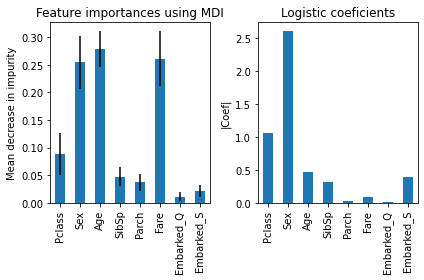

In [100]:
importances_plot(data_1, target, predictors)

As ordinal

In [101]:
data_2 = data.copy()

In [102]:
def next_5_mult(x):
    x = round(x)
    return x + 5 - (x%5)

age_dict = {}
counter = 0
for i in range(5,61,5):
    age_dict[i] = counter
    counter +=1

data_2['Fare'] = pd.qcut(data['Fare'], q=15, labels=[*range(0,15,1)])
data_2['Age'] = data_2['Age'].apply(lambda x: age_dict[next_5_mult(x)] if x<60 else age_dict[60])

In [103]:
mean_1 = get_mean_scores(data_2, target, predictors)
print(mean_1)

[0.77890276818781, 0.8103132257862031]


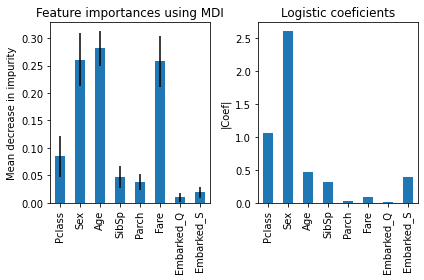

In [104]:
importances_plot(data_1, target, predictors)

Now training only with the two

In [105]:
mean_3 = get_mean_scores(data_1.loc[:,["Age","Fare"]], target, predictors)
print(mean_3)

[0.6633230807858892, 0.6464942564810746]


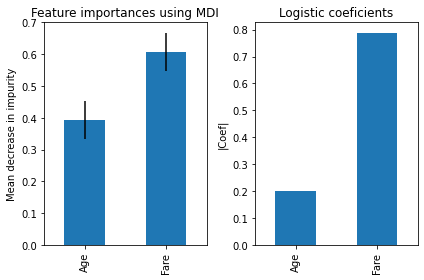

In [106]:
importances_plot(data_1.loc[:,["Age","Fare"]], target, predictors)

In [107]:
mean_4 = get_mean_scores(data_2.loc[:,["Age","Fare"]], target, predictors)
print(mean_4)

[0.6690163831523444, 0.6285669449500972]


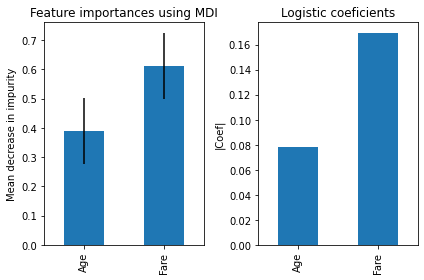

In [108]:
importances_plot(data_2.loc[:,["Age","Fare"]], target, predictors)

The test was not conclusive

## Testing SibSp as binary

In [109]:
data_1 = data.copy()

In [110]:
# Scaling continuos data
ss = StandardScaler()
ss.fit(data_1.loc[:,['Age', 'Fare']])
data_1.loc[:,['Age', 'Fare']] = ss.transform(data_1.loc[:,['Age', 'Fare']])

In [111]:
mean_0 = get_mean_scores(data_1, target, predictors)
print(mean_0)

[0.7845081915761722, 0.8081099742640137]


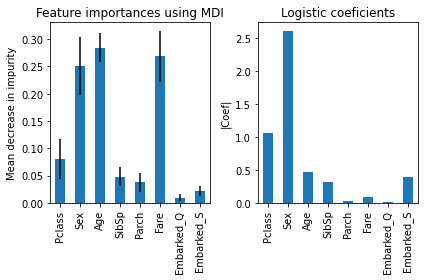

In [112]:
importances_plot(data_1, target, predictors)

In [113]:
data_2 = data.copy()

In [114]:
# Scaling continuos data
ss = StandardScaler()
ss.fit(data_2.loc[:,['Age', 'Fare']])
data_2.loc[:,['Age', 'Fare']] = ss.transform(data_2.loc[:,['Age', 'Fare']])

In [115]:
# Making SibSp binary
data_2['SibSp'] = data_2['SibSp'].apply(lambda x: 1 if x>=1 else 0)

In [116]:
mean_0 = get_mean_scores(data_2, target, predictors)
print(mean_0)

[0.7845081915761722, 0.8058690603226413]


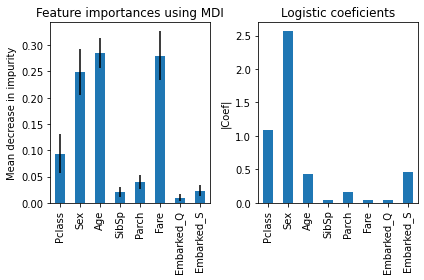

In [117]:
importances_plot(data_2, target, predictors)

#### Conclusion
<br> Binary SibSp lowered the score and got less importance in results

# New Features

### -P_class * Age(categorical)
### -Pclass related to Sex

In [118]:
# Making new features
#p_class * age(cat)
#p_class and sex
pclass_sex_dict = {'f1': 1,"f2":2,"f3":3,
                  "m1":4, "m2":5,"m3":6}

data['pclass_age'] = pd.cut(data['Age'], bins=[*range(0,81,5)],labels=[*range(0,16,1)])

pclass_age = []
pclass_sex = []
for index, row in data.iterrows():
    if row['Sex'] == 1:
        aux = 'f'
    else:
        aux='m'
    aux += str(int(row['Pclass']))
    
    pclass_age.append(row['pclass_age'] * row['Pclass'])
    
    pclass_sex.append(pclass_sex_dict[aux])

data['pclass_age'] = pclass_age
data['pclass_sex'] = pclass_sex
data['pclass_age'] = data['pclass_age'].astype(int)

In [119]:
data.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_Q,Embarked_S,pclass_age,pclass_sex
PassengerId,,,,,,,,,,
1,3,0,22.0,1,0,7.2500,0,1,12,6
2,1,1,38.0,1,0,71.2833,0,0,7,1
3,3,1,26.0,0,0,7.9250,0,1,15,3
4,1,1,35.0,1,0,53.1000,0,1,6,1
5,3,0,35.0,0,0,8.0500,0,1,18,6


In [120]:
data_1 = data.copy()
ss = StandardScaler()
ss.fit(data_1.loc[:,['Age', 'Fare','pclass_age']])
data_1.loc[:,['Age', 'Fare','pclass_age']] = ss.transform(data_1.loc[:,['Age', 'Fare','pclass_age']])

In [121]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

In [122]:
predictors_1=[LogisticRegression(),SVC(),DecisionTreeClassifier(),RandomForestClassifier(),GaussianNB()]

In [123]:
get_mean_scores(data_1, target, predictors_1)

[0.7833783190006904,
 0.8125415855878476,
 0.7688531793358859,
 0.8148327160881301,
 0.7811876216182287]

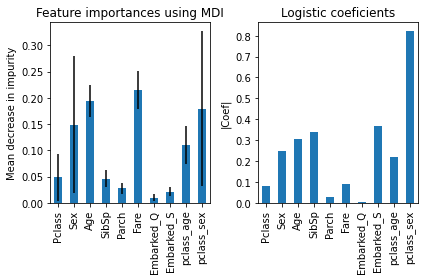

In [124]:
importances_plot(data_1, target, predictors)

### Dropping Embarked_Q, Embarked_S 

as the two have low importance in data

In [125]:
data_2 = data.copy()
data_2.drop(["Embarked_Q", "Embarked_S"], axis=1, inplace=True)
ss = StandardScaler()
ss.fit(data_2.loc[:,['Age', 'Fare','pclass_age']])
data_2.loc[:,['Age', 'Fare','pclass_age']] = ss.transform(data_2.loc[:,['Age', 'Fare','pclass_age']])

In [126]:
get_mean_scores(data_2, target, predictors_1)

[0.7777728956123281,
 0.8136714581633292,
 0.7632226476680686,
 0.8114870378507313,
 0.7778231121712385]

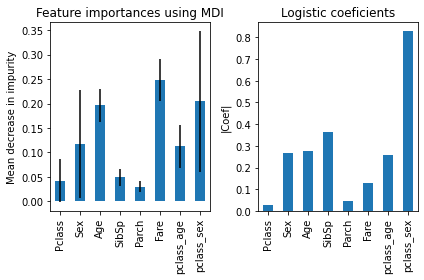

In [127]:
importances_plot(data_2, target, predictors)

No significant lost in score

In [128]:
data.drop(["Embarked_Q", "Embarked_S"], axis=1, inplace=True)

The pclass_sex seems to have better results than p_class alone or than Sex alone, but using both make data redundant. It will be evaluated the removal of it or the removal of the other two.

#### Try: remove pclass and sex

In [129]:
data_without_pclass_and_sex = data.copy()
data_without_pclass_and_sex.drop(["Pclass", "Sex"], axis=1, inplace=True)
ss = StandardScaler()
ss.fit(data_without_pclass_and_sex.loc[:,['Age','Fare','pclass_age']])
data_without_pclass_and_sex.loc[:,['Age','Fare','pclass_age']] = ss.transform(data_without_pclass_and_sex.loc[:,['Age','Fare','pclass_age']])

In [130]:
data_without_pclass_and_sex

,Age,SibSp,Parch,Fare,pclass_age,pclass_sex
PassengerId,,,,,,
1,-0.554642,1,0,-0.502445,0.070759,6
2,0.624066,1,0,0.786845,-0.679791,1
3,-0.259965,0,0,-0.488854,0.521089,3
4,0.403058,1,0,0.420730,-0.829901,1
5,0.403058,0,0,-0.486337,0.971418,6
...,...,...,...,...,...,...
887,-0.186295,0,0,-0.386671,-0.229461,5
888,-0.775649,0,0,-0.044381,-1.280230,1
889,0.697735,1,2,-0.176263,1.421748,3


In [131]:
get_mean_scores(data_without_pclass_and_sex, target, predictors_1)

[0.7800200866235641,
 0.8159249262444291,
 0.7721988575732848,
 0.8148389931579938,
 0.7912748728893353]

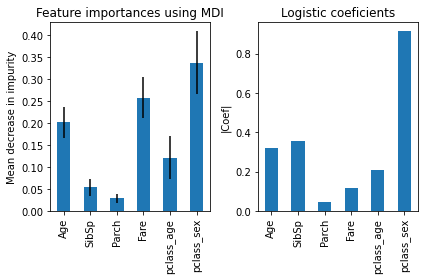

In [132]:
importances_plot(data_without_pclass_and_sex, target, predictors)

Seem to have gained performance within all classifiers

#### Try: remove pclass_sex and keep others

In [133]:
data_without_pclass_sex = data.copy()
data_without_pclass_sex.drop(['pclass_sex'], axis=1, inplace=True)
ss = StandardScaler()
ss.fit(data_without_pclass_sex.loc[:,['Age','Fare','pclass_age']])
data_without_pclass_sex.loc[:,['Age','Fare','pclass_age']] = ss.transform(data_without_pclass_sex.loc[:,['Age','Fare','pclass_age']])

In [134]:
data_without_pclass_sex

,Pclass,Sex,Age,SibSp,Parch,Fare,pclass_age
PassengerId,,,,,,,
1,3,0,-0.554642,1,0,-0.502445,0.070759
2,1,1,0.624066,1,0,0.786845,-0.679791
3,3,1,-0.259965,0,0,-0.488854,0.521089
4,1,1,0.403058,1,0,0.420730,-0.829901
5,3,0,0.403058,0,0,-0.486337,0.971418
...,...,...,...,...,...,...,...
887,2,0,-0.186295,0,0,-0.386671,-0.229461
888,1,1,-0.775649,0,0,-0.044381,-1.280230
889,3,1,0.697735,1,2,-0.176263,1.421748


In [135]:
get_mean_scores(data_without_pclass_sex, target, predictors_1)

[0.7822672776348,
 0.824913690289373,
 0.7677233067604041,
 0.8047329106772958,
 0.7766995166656205]

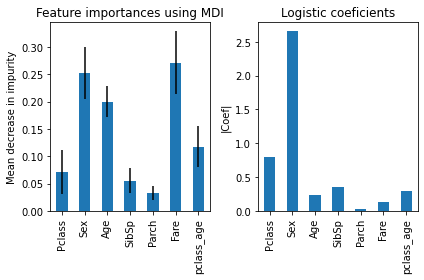

In [136]:
importances_plot(data_without_pclass_sex, target, predictors)

Seem to have gained performance too, but slight better

### Dropping pclass_sex
as it seem to lower the score

In [137]:
data.drop(['pclass_sex'],axis=1, inplace=True)

#### Try: remove Parch

In [138]:
data_without_parch = data.copy()
data_without_parch.drop(['Parch'], axis=1, inplace=True)
ss = StandardScaler()
ss.fit(data_without_parch.loc[:,['Age','Fare','pclass_age']])
data_without_parch.loc[:,['Age','Fare','pclass_age']] = ss.transform(data_without_parch.loc[:,['Age','Fare','pclass_age']])

In [139]:
get_mean_scores(data_without_parch, target, predictors_1)

[0.7845081915761722,
 0.8148013307388112,
 0.7654886698888959,
 0.8058753373925052,
 0.7823237712635741]

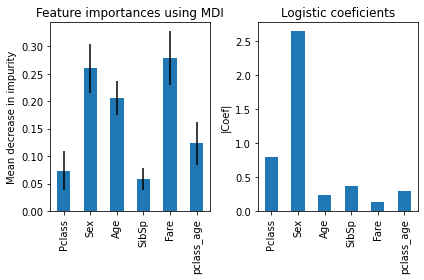

In [140]:
importances_plot(data_without_parch, target, predictors)

No visible effect, some tries performed better, others worse, decision: remove to emphasize the most important features

### Dropping Parch
as it seem to improve the score

#### Try: remove SibSp

In [185]:
data_without_sibsp = data.copy()
data_without_sibsp.drop(['SibSp'], axis=1, inplace=True)
ss = StandardScaler()
ss.fit(data_without_sibsp.loc[:,['Age','Fare','pclass_age']])
data_without_sibsp.loc[:,['Age','Fare','pclass_age']] = ss.transform(data_without_sibsp.loc[:,['Age','Fare','pclass_age']])

In [188]:
get_mean_scores(data_without_sibsp, target, predictors_1)

[0.7822672776348001,
 0.7946393823363254,
 0.76660598832465,
 0.8171112924486849,
 0.7733412842884941]

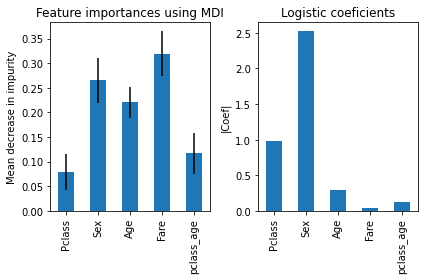

In [190]:
importances_plot(data_without_sibsp, target, predictors)

Worse results: keeping it

### Try: remove pclass_age

In [192]:
data_without_pclass_age = data.copy()
data_without_pclass_age.drop(['pclass_age'], axis=1, inplace=True)
ss = StandardScaler()
ss.fit(data_without_pclass_age.loc[:,['Age','Fare']])
data_without_pclass_age.loc[:,['Age','Fare']] = ss.transform(data_without_pclass_age.loc[:,['Age','Fare']])

In [195]:
get_mean_scores(data_without_pclass_age, target, predictors_1)

[0.7833783190006904,
 0.8091833532107211,
 0.7767309020149394,
 0.8171112924486849,
 0.7834159814198733]

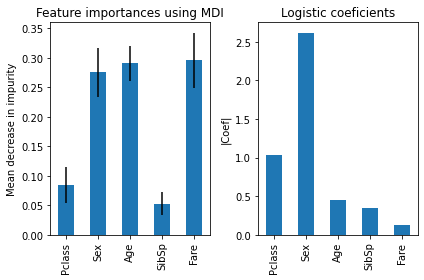

In [194]:
importances_plot(data_without_pclass_age, target, predictors)

Results worse: keeping it

In [197]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      891 non-null    int64  
 1   Sex         891 non-null    int64  
 2   Age         891 non-null    float64
 3   SibSp       891 non-null    int64  
 4   Fare        891 non-null    float64
 5   pclass_age  891 non-null    int64  
dtypes: float64(2), int64(4)
memory usage: 48.7 KB


# Conclusion
### Keeping:
Pclass

Sex

Age - filling with same mean and std

SibSp

Fare

pclass_age
### Stages
Fill missing Age values

Standard Scale for Age, Fare and pclass_age

Train and optimize with SVC and Random Forest, to get best prediction